In [1]:
import yaml
from scipy import special
import numpy as np
from math import *
from os import mkdir
from sys import argv
from matplotlib import pylab as plt
from scipy.integrate import quad,quadrature,nquad
from math import sqrt,cos, log, pi
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions import get_data, integral2, Jfactor
from multiprocessing import Pool
%matplotlib inline

names = {'booI':"Bootes I",'booII':"Bootes II",'car':"Carina",'com':"Coma Berenices",
'cvnI':"Canes Venatici I",'cvnII':"Canes Venatici II",'dra':"Draco",'for':"Fornax",
'her':"Hercules",'leoI':"Leo I",'leoIV':"Leo IV",'leoT':"Leo T",'scl':"Sculptor",
'seg1':"Segue 1",'sex':"Sextans",'sgr':"Sagittarius",'umaI':"Ursa Major I",
'umaII':"Ursa Major II",'umi':"Ursa Minor",'wil1':"Willman 1"}

In [2]:
# dwarf surface brightness profile
def I(R,rh):
    return 4./3. * rh/(1+(R/rh)**2)**2

In [3]:
dwarf = 'leoIV'
R,v,dv,rh,rt,nstars,D = get_data(dwarf)
u=v.mean()
beta=-0.005

In [4]:
gamma_array = R/rh
A_array = gamma_array**(1.-2.*beta)/I(R,rh)
r0_array = np.logspace(-3,3,200)
alpha_array = rh/r0_array
I_array=np.zeros(shape=(len(A_array),len(r0_array)))

In [5]:
def array_builder(a_array, b, g_array):
    for i,g in enumerate(g_array):
        for j,a in enumerate(a_array):
            yield (i, j), (a, b, g)

def proxy(args):
    return args[0], integral2(*args[1])*A_array[args[0][0]]

In [6]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(alpha_array, beta, gamma_array))
pool.close()
pool.join()
for idx,value  in results:
    I_array[idx] = value

In [7]:
Jf = np.sqrt([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])

cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(J,i):
    I = cst*sqrt(J)*r0_array[i]**3*I_array[:,i]/Jf[i]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg)


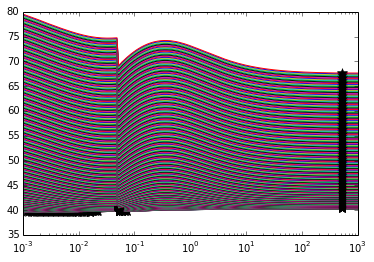

In [8]:
J_array = np.linspace(14,22,500)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
min_r0_arr = np.empty([0])

for J in J_array:                                                  # scan over an array of J values
    LikeJr0 = np.zeros_like(r0_array)
    for i in range(r0_array.size): LikeJr0[i] = logLike(10**J,i) # for each J scan over an array of r0 values
    interp_Like_r0 = interp(r0_array,LikeJr0)                      # build the profile likelihood along ra
        
    eval_Like_r0 = np.logspace(log10(r0_array.min()),log10(r0_array.max()),1e3)
    min_Like_r0 = interp_Like_r0(eval_Like_r0).min()
    min_r0 = eval_Like_r0[np.where(interp_Like_r0(eval_Like_r0)==min_Like_r0)[0]]
    
    if r0_array[1]<min_r0<r0_array[-2]:
        plt.semilogx(r0_array,interp_Like_r0(r0_array),label='J=%.2f'%J)
        plt.plot(min_r0,min_Like_r0,'*',markersize=10,c='k')

        min_r0_arr = np.append(min_r0_arr,min_r0)
        min_LikeJ = np.append(min_LikeJ,min_Like_r0)
        J_new = np.append(J_new,J)

#plt.ylim(102,104)
#plt.xlim(1e-2,1e0)
#plt.legend(bbox_to_anchor=(1.4,1))

min J =  17.24  , r0 =  0.053  , rh =  0.152


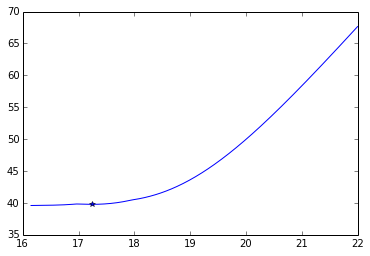

In [9]:
interp_Like = interp(J_new,min_LikeJ)
interp_Like_r0 = interp(J_new,min_r0_arr)
J_min = sciopt.minimize_scalar(interp_Like,method='Bounded',bounds=(J_new[0],J_new[-1])).x
J_r0 = interp_Like_r0(J_min)
print 'min J = ',round(J_min,2),' , r0 = ',round(J_r0,3),' , rh = ',rh
plt.plot(J_new,interp_Like(J_new))
plt.plot(J_min,interp_Like(J_min),'b*')
#plt.ylim(240,260)

In [10]:
def one_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(J_min)-0.5)

one_sigma_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
one_sigma_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

def two_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(J_min)-2.)

two_sigma_l = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
two_sigma_r = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

def three_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(J_min)-4.)

three_sigma_l = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
three_sigma_r = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

In [11]:
print round(J_min,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

17.24 -0.27 0.61 -0.27 1.3 -0.27 1.79


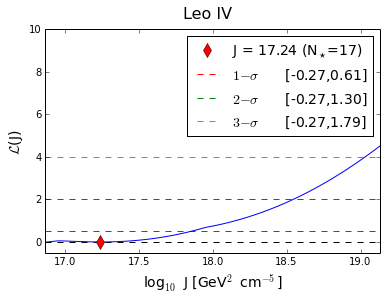

In [12]:
if J_min+three_sigma_l-0.1>J_new[0]: J_i = J_min+three_sigma_l-0.1
else: J_i = J_new[0]
if J_min+three_sigma_r+0.1<J_new[-1]: J_f = J_min+three_sigma_r+0.1
else: J_f = J_new[-1]
J_plt = np.linspace(J_i,J_f,100)
plt.plot(J_plt,interp_Like(J_plt)-interp_Like(J_min))
plt.plot(J_min,0.,'rd',markersize=10,label='J = %.2f'%J_min+r' (N$_\star$=%i)'%nstars)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,loc='upper right',fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,10)
plt.xlim(J_i,J_f)
#plt.savefig('../output/bfix/results/%s/LikeJ_%s.png'%(dwarf,dwarf),dpi=300,format='png')
plt.suptitle('%s'%names[dwarf],fontsize=16)
#plt.savefig('../output/bfix/results/%s/LikeJ_%s_title.png'%(dwarf,dwarf),dpi=300,format='png')